## Multilayer Perceptron Example

MNIST dataset

* 60K grayscale images (28x28)
* Picture of a digit plus label



In [1]:
import mxnet as mx
import numpy as np
import os, time, shutil
import zipfile, os
from gluoncv.utils import download

from mxnet import gluon, image, init, nd
from mxnet import autograd as ag
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms
from gluoncv.utils import makedirs


/Users/kannanva/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## NDArray

* N Dimensional array or Tensor
* Identified by data type, shape
* MXNet’s primary tool for storing and transforming data.

In [2]:
# Creating a 2D Tensor
x = nd.array(((1, 2, 3), (5, 6, 7)))

# 2x3 tensor with random data
y = nd.random.uniform(low=-1, high=1, shape=(2,3))

print (x.shape, x.size, x.dtype, x.context)

# matrix multiplication
print (nd.dot(x, y.T))

# convert to numpy
a = x.asnumpy()
print (type(a), a)

# convert back to NDArray
nd.array(a)

(2, 3) 6 <class 'numpy.float32'> cpu(0)

[[1.7601415 3.2472587]
 [4.614921  9.687056 ]]
<NDArray 2x2 @cpu(0)>
<class 'numpy.ndarray'> [[1. 2. 3.]
 [5. 6. 7.]]



[[1. 2. 3.]
 [5. 6. 7.]]
<NDArray 2x3 @cpu(0)>

## Automatic differentiation with autograd

* Goal: minimize a loss function.
* How?
    1. compute the gradient of the loss with respect to weights
    2. update the weights accordingly
* autograd package expedites this work by automatically calculating derivatives.

Differentiate

$f(x) = 2 x^2$ 

with respect to parameter $x$.

$y=2x^2$  

$\frac{dy}{dx} = 4x$

In [24]:
x = nd.array([[1, 2], [3, 4]])

x.attach_grad()

def f(x):
    return 2 * x**2

with ag.record():
    y = f(x)

print (x, y)

y.backward()

x, x.grad


[[1. 2.]
 [3. 4.]]
<NDArray 2x2 @cpu(0)> 
[[ 2.  8.]
 [18. 32.]]
<NDArray 2x2 @cpu(0)>


(
 [[1. 2.]
  [3. 4.]]
 <NDArray 2x2 @cpu(0)>, 
 [[ 4.  8.]
  [12. 16.]]
 <NDArray 2x2 @cpu(0)>)

In [3]:
from multiprocessing import cpu_count

# number of CPUs avalaible
CPU_COUNT = cpu_count()

num_gpu_range = mx.test_utils.list_gpus()

# set context for training or inference in future
ctx = [mx.gpu(i) for i in num_gpu_range] \
if num_gpu_range.stop > num_gpu_range.start else [mx.cpu()]


## Load data

### Handwritten digits dataset

* Grayscale: one byte for color channel
* Input data is `(batch_size, 1, 28, 28)`

## Dataset, DataLoader and Transforms
[Dataset](https://mxnet.incubator.apache.org/api/python/gluon/data.html#mxnet.gluon.data.Dataset) - used to represent collection of data.  
[DataLoader](https://mxnet.incubator.apache.org/api/python/gluon/data.html#mxnet.gluon.data.DataLoader) - mini-batches of data from Dataset, iterator interface, can load data in parallel.  
[Transforms](https://mxnet.incubator.apache.org/api/python/gluon/data.html#vision-transforms) - Transformations that can applied on data for augmentation, multiple transforms can composed to apply sequentially on the data. 

In [4]:
from mxnet import gluon
from mxnet.gluon.data.vision import transforms

batch_size = 100

# Load training/test data
train_dataset = gluon.data.vision.MNIST(train=True).transform_first(transforms.ToTensor())
# data loader to traverse the dataset in batches.
train_data = gluon.data.DataLoader(train_dataset, 
                                   batch_size=batch_size,
                                   shuffle=True, 
                                   num_workers=CPU_COUNT)

val_dataset = gluon.data.vision.MNIST(train=False).transform_first(transforms.ToTensor())
val_data = gluon.data.DataLoader(val_dataset, 
                                 batch_size=batch_size, num_workers=CPU_COUNT)

### Visualize the data

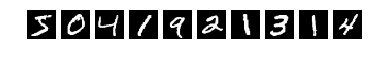

label: 5 0 4 1 9 2 1 3 1 4


In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_dataset[i][0][0].asnumpy(), cmap='Greys_r')
    plt.axis('off')
plt.show()
print('label: %s' % ' '.join([str(train_dataset[i][1]) for i in range(10)]))

### Data shape

* Image batches are commonly represented by a shape (batch_size, num_channels, width, height). 
* For the MNIST dataset, the shape of input is (batch_size, 1, 28, 28).

In [6]:
data_shape = None
label_shape = None
for X_batch, y_batch in train_data:
    print("X_batch has shape {}, and y_batch has shape {}".format(X_batch.shape, y_batch.shape))
    data_shape = X_batch.shape
    label_shape = y_batch.shape
    break

X_batch has shape (100, 1, 28, 28), and y_batch has shape (100,)


## Define the network

A Multi-Layer Perceptron with 3 dense/fully-connected layers.

Gluon Block - Base class for all neural network layers and models.
* A layer is a block
* Multiple layers together can make a block
* Nested blocks

## Deep Learning Programming Styles: Imperative vs  Symbolic

Imperative style:
* Tell the machine "how" to do it
* Changes the program state

Symbolic/declarative style:
* Tell the machine "what" to do
* Build the structure and elements


#### Example (Ref: http://latentflip.com/imperative-vs-declarative)
Declarative: 

`SELECT * from dogs INNER JOIN owners WHERE dogs.owner_id = owners.id`

Imperative:

`
//dogs = [{name: 'Fido', owner_id: 1}, {...}, ... ]
//owners = [{id: 1, name: 'Bob'}, {...}, ...]

var dogsWithOwners = []
var dog, owner

for(var di=0; di < dogs.length; di++) {
  dog = dogs[di]

  for(var oi=0; oi < owners.length; oi++) {
    owner = owners[oi]
    if (owner && dog.owner_id == owner.id) {
      dogsWithOwners.push({
        dog: dog,
        owner: owner
      })
    }
  }}
}
`

### HybridBlock

* Gluon introduces hybrid programming through HybridBlock. 
* Combines declarative programming and imperative programming. 
* Users can quickly develop and debug models with imperative programming and switch to efficient declarative execution by simply calling: HybridBlock.hybridize().

In [19]:
net = nn.HybridSequential()

with net.name_scope():
    net.add(nn.Dense(128, activation='relu'))
    net.add(nn.Dense(64, activation='relu'))
    net.add(nn.Dense(10))

In [8]:
net.hybridize()

### Visualize network

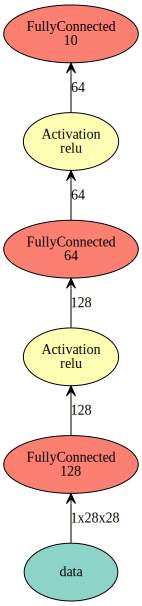

In [9]:
x = mx.sym.var('data')
sym = net(x)
mx.viz.plot_network(sym, \
                    node_attrs={"shape":"oval","fixedsize":"false"}, \
                    shape={"data": data_shape})

## Initialize parameters and optimizer


In [10]:
# initialize network parameters
# Xavier initialization - avoid vanishing/exploding gradients
# Gaussian distribution with zero mean and a suitable variance
net.initialize(mx.init.Xavier(), ctx=ctx)

# Trainer applies an Optimizer on a set of Parameters
# Takes the parameters to be optimized, optimizer to use, and
# optimizer params as arguments
trainer = gluon.Trainer(net.collect_params(),
                        'sgd',
                        {'learning_rate': 0.02})

## Train the network

In [11]:
# define accuracy metric
metric = mx.metric.Accuracy()

# define loss function
L = gluon.loss.SoftmaxCrossEntropyLoss()

In [12]:
# validation loop
def test(net, val_data, ctx):
    metric = mx.metric.Accuracy()
    for i, batch in enumerate(val_data):
        # Splits data into `len(ctx_list)` slices along `batch_axis` and loads
        # each slice to one context in `ctx_list`
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        # forward pass
        outputs = [net(X) for X in data]
        metric.update(label, outputs)

    return metric.get()

### Training Loop

In [13]:
num_batch = len(train_data)
epochs = 10
train_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    tic = time.time()
    train_loss = 0
    metric.reset()

    for i, batch in enumerate(train_data):
        # Splits data into `len(ctx_list)` slices along `batch_axis` and loads
        # each slice to one context in `ctx_list`
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0, even_split=False)
        label = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0, even_split=False)
        # autograd records computation history to calculate gradients later. 
        with ag.record():
            # pass each slice of data to the network's forward pass and collect output            
            outputs = [net(X) for X in data]
            # compute loss
            loss = [L(yhat, y) for yhat, y in zip(outputs, label)]
        # for each loss in the batch, backpropagate            
        for l in loss:
            l.backward()
        # Makes one step of parameter update.
        trainer.step(batch_size)
        # loss over the batch
        train_loss += sum([l.mean().asscalar() for l in loss]) / len(loss)

        # update metric
        metric.update(label, outputs)

    # metrics for the epoch
    _, train_acc = metric.get()
    train_loss /= num_batch
    
    _, val_acc = test(net, val_data, ctx)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print('[Epoch %d] Train-acc: %.3f, loss: %.3f | Val-acc: %.3f | time: %.1f' %
             (epoch, train_acc, train_loss, val_acc, time.time() - tic))

[Epoch 0] Train-acc: 0.797, loss: 0.778 | Val-acc: 0.898 | time: 4.7
[Epoch 1] Train-acc: 0.904, loss: 0.339 | Val-acc: 0.913 | time: 4.0
[Epoch 2] Train-acc: 0.920, loss: 0.282 | Val-acc: 0.927 | time: 4.1
[Epoch 3] Train-acc: 0.930, loss: 0.249 | Val-acc: 0.933 | time: 4.1
[Epoch 4] Train-acc: 0.936, loss: 0.223 | Val-acc: 0.939 | time: 4.0
[Epoch 5] Train-acc: 0.943, loss: 0.203 | Val-acc: 0.945 | time: 5.2
[Epoch 6] Train-acc: 0.947, loss: 0.187 | Val-acc: 0.947 | time: 7.7
[Epoch 7] Train-acc: 0.951, loss: 0.172 | Val-acc: 0.951 | time: 7.9
[Epoch 8] Train-acc: 0.954, loss: 0.160 | Val-acc: 0.954 | time: 5.6
[Epoch 9] Train-acc: 0.957, loss: 0.149 | Val-acc: 0.956 | time: 5.3


### Plot Training and Validataion Loss/Accuracy 

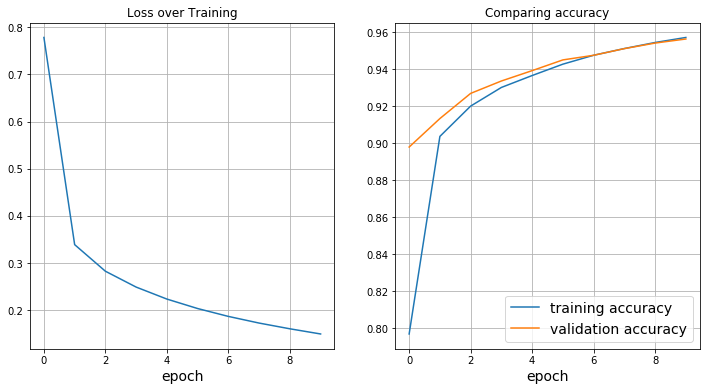

In [14]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

f = plt.figure(figsize=(12,6))
fg1 = f.add_subplot(121)
fg2 = f.add_subplot(122)

fg1.set_xlabel('epoch',fontsize=14)  
fg1.set_title('Loss over Training')
fg1.grid(True, which="both")
fg1.plot(range(epochs), train_losses)

fg2.set_title('Comparing accuracy')
fg2.set_xlabel('epoch', fontsize=14)
fg2.grid(True, which="both")

p1, = fg2.plot(range(epochs), train_accuracies)
p2, = fg2.plot(range(epochs), val_accuracies)
fg2.legend([p1, p2], ['training accuracy', 'validation accuracy'],fontsize=14) 

### Test Accuracy

In [15]:
# evaluate the trained model by running predictions on validation dataset
_, test_acc = test(net, val_data, ctx)
print('[Finished] Test-acc: %.3f' % (test_acc))

[Finished] Test-acc: 0.956


## Prediction

* Also called _Inference_
* Evaluate against unseen data
* Ensure model is not overfit
* We want models that generalize

prediction: 1, ground truth label: 1
prediction: 9, ground truth label: 9
prediction: 1, ground truth label: 1
prediction: 3, ground truth label: 3
prediction: 9, ground truth label: 9
prediction: 0, ground truth label: 0
prediction: 1, ground truth label: 1
prediction: 0, ground truth label: 0
prediction: 4, ground truth label: 4
prediction: 9, ground truth label: 9


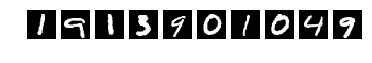

In [16]:
import numpy as np
for i in range(10):
    plt.subplot(1, 10, i+1)
    idx = np.random.randint(1, 10000)
    d = val_dataset[idx][0][0].asnumpy()
    x  = (mx.nd.expand_dims(mx.nd.array(d), axis=0))
    #forward pass
    prediction = net(x.as_in_context(ctx[0]))
    prediction = np.squeeze(prediction.asnumpy())
    prediction = np.argmax(prediction)
    print('prediction: %s, ground truth label: %s' % (prediction, val_dataset[idx][1]))
    plt.imshow(d, cmap='Greys_r')
    plt.axis('off')
plt.show()

## Export model

In [17]:
net.export('gluon-mnist')

In [18]:
!ls ./gluon-mnist*

./gluon-mnist-0000.params ./gluon-mnist-symbol.json
